In [1]:
#preriquisite for loading model output
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Introduction

One area where deep learning has dramatically improved in the last couple of years is natural language processing (NLP). Computers can now generate text, translate automatically from one language to another, analyze comments, label words in sentences, and much more.

Perhaps the most widely practically useful application of NLP is *classification* -- that is, classifying a document automatically into some category. This can be used, for instance, for:

- `Sentiment analysis (e.g are people saying *positive* or *negative* things about your product)`
- `Author identification (what author most likely wrote some document)`
- Legal discovery (which documents are in scope for a trial)
- Organizing documents by topic
- Triaging inbound emails
- ...and much more!

Classification models can also be used to solve problems that are not, at first, obviously appropriate. For instance, consider the Kaggle [U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/) competition. In this, we are tasked with comparing two words or short phrases, and scoring them based on whether they're similar or not, based on which patent class they were used in. With a score of `1` it is considered that the two inputs have identical meaning, and `0` means they have totally different meaning. For instance, *abatement* and *eliminating process* have a score of `0.5`, meaning they're somewhat similar, but not identical.

It turns out that this can be represented as a classification problem. How? By representing the question like this:

> For the following text...: "TEXT1: abatement; TEXT2: eliminating process" ...chose a category of meaning similarity: "Different; Similar; Identical".

In this notebook we'll see how to solve the Patent Phrase Matching problem by treating it as a classification task, by representing it in a very similar way to that shown above.

We've been mainly been dealing with images and now , lets learn about how to apply deep learning on documents. 


`what are documents?` these are inputs to an nlp model that contains text.

`classification` is a huge space for those interested in NLP

We'll need slightly different code depending on whether we're running on Kaggle or not, so we'll use this variable to track where we are:

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

## using Kaggle on your own machine

Kaggle limits your weekly time using a GPU machine. The limits are very generous, but you may well still find it's not enough! In that case, you'll want to use your own GPU server, or a cloud server such as Colab, Paperspace Gradient, or SageMaker Studio Lab (all of which have free options). To do so, you'll need to be able to download Kaggle datasets.

The easiest way to download Kaggle datasets is to use the Kaggle API. You can install this using `pip` by running this in a notebook cell:

    !pip install kaggle

You need an API key to use the Kaggle API; to get one, click on your profile picture on the Kaggle website, and choose My Account, then click Create New API Token. This will save a file called *kaggle.json* to your PC. You need to copy this key on your GPU server. To do so, open the file you downloaded, copy the contents, and paste them in the following cell (e.g., `creds = '{"username":"xxx","key":"xxx"}'`):


In [3]:
creds = '{"username":"brainhostdotexe","key":"9187295120509267d5636079d8cf238a"}'

Then execute this cell (this only needs to be run once):

In [4]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Now you can download datasets from Kaggle.

In [5]:
path = Path('us-patent-phrase-to-phrase-matching')

And use the Kaggle API to download the dataset to that path, and extract it:

In [6]:
# if not iskaggle and not path.exists():
#     import zipfile,kaggle
#     kaggle.api.competition_download_cli(str(path))
#     zipfile.ZipFile(f'{path}.zip').extractall(path)

Note that you can easily download notebooks from Kaggle and upload them to other cloud services. So if you're low on Kaggle GPU credits, give this a try!

## Import and EDA

In [7]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets

It looks like this competition uses CSV files. For opening, manipulating, and viewing CSV files, it's generally best to use the Pandas library, which is explained brilliantly in [this book](https://wesmckinney.com/book/) by the lead developer (it's also an excellent introduction to matplotlib and numpy, both of which I use in this notebook). Generally it's imported as the abbreviation `pd`.

In [8]:
import pandas as pd

There are 4 relevant libraries in NLP:
- `numpy` ~basic numerical programming
- `matplotlib` ~ plotting
- `pandas` ~ tables of data
- `pytorch` ~ deep learning

To check out pandas, check out `python for data analysis by wes mckinney`

with pandas we can now read our csv file


In [9]:
path = 'C:/Users/BM/ML fastai/lesson 4/U.S. Patent Phrase to Phrase Matching/train.csv'

In [10]:
df = pd.read_csv('C:/Users/BM/ML fastai/lesson 4/U.S. Patent Phrase to Phrase Matching/train.csv')

This creates a [DataFrame](https://pandas.pydata.org/docs/user_guide/10min.html), which is a table of named columns, a bit like a database table. To view the first and last rows, and row count of a DataFrame, just type its name:

In [11]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


It's important to carefully read the [dataset description](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data) to understand how each of these columns is used.

One of the most useful features of `DataFrame` is the `describe()` method:

In [12]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


`describe method()` is used to get the description of objects or fields in your dataset.

As we can see, the `anchor` column tells us that there are 733 unique anchors, the `target` column tells us there about 30000 unique targets.

ok then, lets create a text that contains context, target and anchor with a field separator in between them

In [13]:
df['input'] = 'TEXT1: ' + df.context + ':TEXT2: '+ df.target +': ANC1: '+ df.anchor

in pandas we can use refer to a column by using square brackets or treat it as an attribute. When setting it, use square brackets with the column name inside quotes. When reading it call it as an attribute

`head` is the first few rows

In [14]:
df.input.head()

0    TEXT1: A47:TEXT2: abatement of pollution: ANC1...
1    TEXT1: A47:TEXT2: act of abating: ANC1: abatement
2    TEXT1: A47:TEXT2: active catalyst: ANC1: abate...
3    TEXT1: A47:TEXT2: eliminating process: ANC1: a...
4     TEXT1: A47:TEXT2: forest region: ANC1: abatement
Name: input, dtype: object

## Tokenization

Now, we've got some documents that we can work with . But as you can remeber, neural networks work with numbers.

first, we'll have to split these up into tokens. Tokens are basically just words.

after that, we will get a list of all the unique words that appear ie the `vocabulary`. And every one of the unique words is going to get a number. 

Remmber that a big vocabulary takes on more memory and time so we don't want a big vocabulary.

thus the process`tokenization` is whereby we split words into smaller unit-like words. and these unit-like words will be `tokens`

We are now going to turn our pandas dataframe into a huggingface datasets. not to be confused with pytorch's dataset

In [15]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

In [16]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

if we take a look , it has the same features the dataframe had plus the input we just added with the concantenates strings

Now ,w e have to split up the words into tokens ie `tokenization` and turn each token into its unique id based on its position in the vocabulary ie `numericalization`

before you start tokenizing, you have to decide on which model to use since the tokenization , vocabulary and numericallization will follow the models format.

the good thing is tat hugging face has multiple models .

for now we will fetch `debarta-v3-small` from microsoft.


In [17]:
model_nm = 'microsoft/deberta-v3-small'

to use the model, we will use `Autotokenizer` to create a tokenizer appropriate for this model

In [18]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
tokz.tokenize("Signs that your problem requires more data")

['▁Signs', '▁that', '▁your', '▁problem', '▁requires', '▁more', '▁data']

In [20]:
tokz.tokenize(" A platypus is an ornithorthynchus anatinus")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'nit',
 'hor',
 'th',
 'yn',
 'chus',
 '▁an',
 'at',
 'inus']

The words that are in the dictionary/model start with an underscore and the ones not recognized are plain text. the model tries to split them up into what it knows

Lets now tokenize our inputs

In [21]:
def tok_func(x):
    return tokz(x['input'])

This is a function that grabs our document , takes the `input` and tokenizes it.

if we want all the processes to run the function at the same time(parralelization) we use map.

In [22]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

lets pry open the `tok_ds`

In [23]:
tokz.tokenize("'TEXT1: A47:TEXT2: abatement of pollution: ANC1: abatement'")

["▁'",
 'TEXT',
 '1',
 ':',
 '▁A',
 '47',
 ':',
 'TEXT',
 '2',
 ':',
 '▁abatement',
 '▁of',
 '▁pollution',
 ':',
 '▁ANC',
 '1',
 ':',
 '▁abatement',
 "'"]

In [24]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47:TEXT2: abatement of pollution: ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  294,
  104917,
  445,
  294,
  47284,
  265,
  6435,
  294,
  23702,
  435,
  294,
  47284,
  2])

to check the numerical id of a word use `vocab`

In [25]:
tokz.vocab[ '▁of']

265

`remember that TEXT1,Text2 and ANC1 are headers and separators of the sentence to help the model know where the sentence starts and stops`

Looking above at our input IDs, we do indeed see that `265` appears as expected.

Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name `labels`, but in our dataset it's currently `score`. Therefore, we need to rename it:

In [26]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

Now that we've prepared our tokens and labels, we need to create our validation set.

## Test and validation sets

in the `us patent` folder you may have downloaded `test.csv`

In [27]:
eval_df = pd.read_csv('C:/Users/BM/ML fastai/lesson 4/U.S. Patent Phrase to Phrase Matching/test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


test sets are used to fix overfitting

### Validation set

To explain the motivation, let's start simple, and imagine we're trying to fit a model where the true relationship is this quadratic:

In [28]:
def f(x): return -3*x**2 + 2*x + 20

Unfortunately matplotlib (the most common library for plotting in Python) doesn't come with a way to visualize a function, so we'll write something to do this ourselves:

In [29]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

Here's what our function looks like:

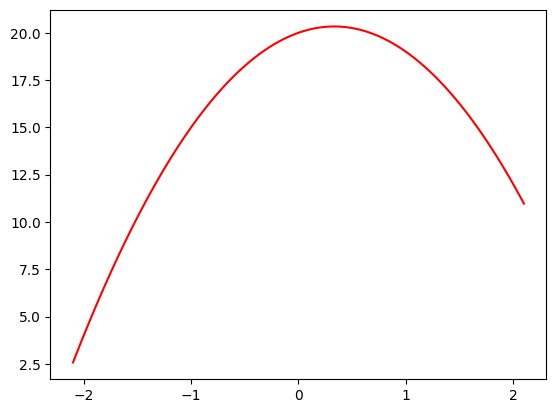

In [30]:
plot_function(f)

For instance, perhaps we've measured the height above ground of an object before and after some event. The measurements will have some random error. We can use numpy's random number generator to simulate that. I like to use `seed` when writing about simulations like this so that I know you'll see the same thing I do:

In [31]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

Here's a function `add_noise` that adds some random variation to an array:

In [32]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

Let's use it to simulate some measurements evenly distributed over time:

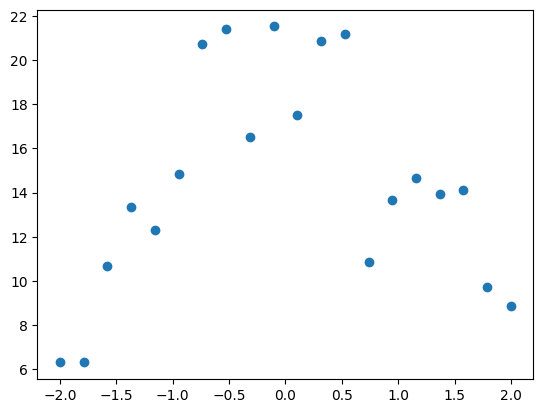

In [33]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

Now let's see what happens if we *underfit* or *overfit* these predictions. To do that, we'll create a function that fits a polynomial of some degree (e.g. a line is degree 1, quadratic is degree 2, cubic is degree 3, etc). The details of how this function works don't matter too much so feel free to skip over it if you like!  (PS: if you're not sure about the jargon around polynomials, here's a [great video](https://www.youtube.com/watch?v=ffLLmV4mZwU) which teaches you what you'll need to know.)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

So, what happens if we fit a line (a "degree 1 polynomial") to our measurements?

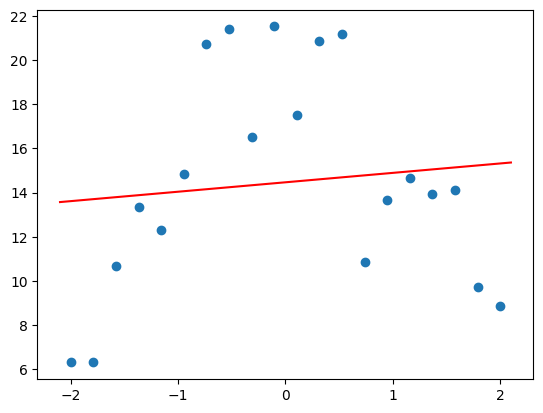

In [35]:
plot_poly(1)

As you see, the points on the red line (the line we fitted) aren't very close at all. This is *under-fit* -- there's not enough detail in our function to match our data.

And what happens if we fit a degree 10 polynomial to our measurements?

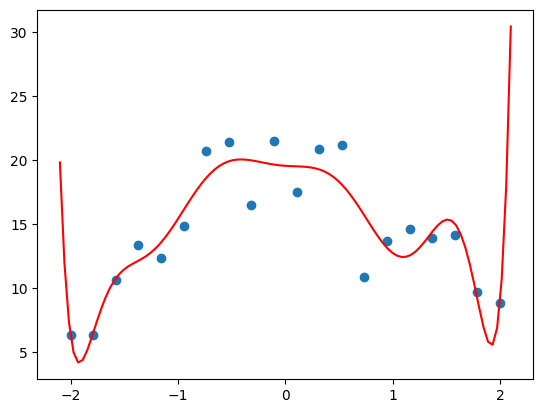

In [36]:
plot_poly(10)

Well now it fits our data better, but it doesn't look like it'll do a great job predicting points other than those we measured -- especially those in earlier or later time periods. This is *over-fit* -- there's too much detail such that the model fits our points, but not the underlying process we really care about.

Let's try a degree 2 polynomial (a quadratic), and compare it to our "true" function (in blue):

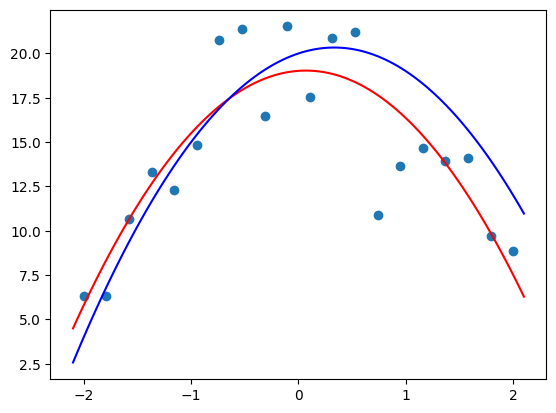

In [37]:
plot_poly(2)
plot_function(f, color='b')

That's not bad at all!

So, how do we recognise whether our models are under-fit, over-fit, or "just right"? We use a *validation set*. This is a set of data that we "hold out" from training -- we don't let our model see it at all. If you use the fastai library, it automatically creates a validation set for you if you don't have one, and will always report metrics (measurements of the accuracy of a model) using the validation set.

The validation set is *only* ever used to see how we're doing. It's *never* used as inputs to training the model.

Transformers uses a `DatasetDict` for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use `train_test_split`:

In [38]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

As you see above, the validation set here is called `test` and not `validate`, so be careful!

In practice, a random split like we've used here might not be a good idea -- here's what Dr Rachel Thomas has to say about it:

> "*One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). Depending on the nature of your data, choosing a validation set can be the most important step. Although sklearn offers a `train_test_split` method, this method takes a random subset of the data, which is a poor choice for many real-world problems.*"

I strongly recommend reading her article [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) to more fully understand this critical topic.

`in short,`
`1. a validation set is used to measure metrics`

`2. metrics are used to tell you how good your model is`

`3. a metric may be similar to a loss function but the difference is that loss function gives you a bumpy curve due to noise while a metric gives you a smooth curve`

`4. in real life there are no metrics given. this is due to all the chaos inside a given model`

### Test set

So that's the validation set explained, and created. What about the "test set" then -- what's that for?

The *test set* is yet another dataset that's held out from training. But it's held out from reporting metrics too! The accuracy of your model on the test set is only ever checked after you've completed your entire training process, including trying different models, training methods, data processing, etc.

You see, as you try all these different things, to see their impact on the metrics on the validation set, you might just accidentally find a few things that entirely coincidentally improve your validation set metrics, but aren't really better in practice. Given enough time and experiments, you'll find lots of these coincidental improvements. That means you're actually over-fitting to your validation set!

That's why we keep a test set held back. Kaggle's public leaderboard is like a test set that you can check from time to time. But don't check too often, or you'll be even over-fitting to the test set!

Kaggle has a *second* test set, which is yet another held-out dataset that's only used at the *end* of the competition to assess your predictions. That's called the "private leaderboard". Here's a [great post](https://gregpark.io/blog/Kaggle-Psychopathy-Postmortem/) about what can happen if you overfit to the public leaderboard.

We'll use `eval` as our name for the test set, to avoid confusion with the `test` dataset that was created above.

In [39]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

## Metrics and correlation

When we're training a model, there will be one or more *metrics* that we're interested in maximising or minimising. These are the measurements that should, hopefully, represent how well our model will works for us.

In real life, outside of Kaggle, things not easy... As my partner Dr Rachel Thomas notes in [The problem with metrics is a big problem for AI](https://www.fast.ai/2019/09/24/metrics/):

>  At their heart, what most current AI approaches do is to optimize metrics. The practice of optimizing metrics is not new nor unique to AI, yet AI can be particularly efficient (even too efficient!) at doing so. This is important to understand, because any risks of optimizing metrics are heightened by AI. While metrics can be useful in their proper place, there are harms when they are unthinkingly applied. Some of the scariest instances of algorithms run amok all result from over-emphasizing metrics. We have to understand this dynamic in order to understand the urgent risks we are facing due to misuse of AI.

In Kaggle, however, it's very straightforward to know what metric to use: Kaggle will tell you! According to this competition's [evaluation page](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview/evaluation), "*submissions are evaluated on the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the predicted and actual similarity scores*." This coefficient is usually abbreviated using the single letter *r*. It is the most widely used measure of the degree of relationship between two variables.

r can vary between `-1`, which means perfect inverse correlation, and `+1`, which means perfect positive correlation. The mathematical formula for it is much less important than getting a good intuition for what the different values look like. To start to get that intuition, let's look at some examples using the [California Housing](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) dataset, which shows "*is the median house value for California districts, expressed in hundreds of thousands of dollars*". This dataset is provided by the excellent [scikit-learn](https://scikit-learn.org/stable/) library, which is the most widely used library for machine learning outside of deep learning.

In [40]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


`each row in housing is a district and what house characteristics are there`

In [41]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [42]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [43]:
def corr(x,y):
    return np.corrcoef(x,y)[0][1]

In [44]:
corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906005

In [45]:
def show_corr(df, a, b):
    x,y = df[a], df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs [b]; r: {corr(x,y):.2f}')

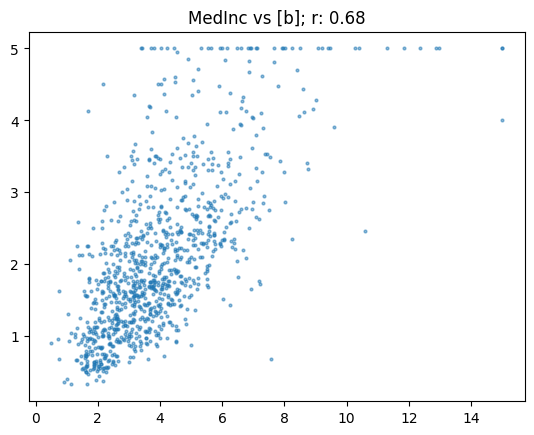

In [46]:
show_corr(housing, 'MedInc', 'MedHouseVal')

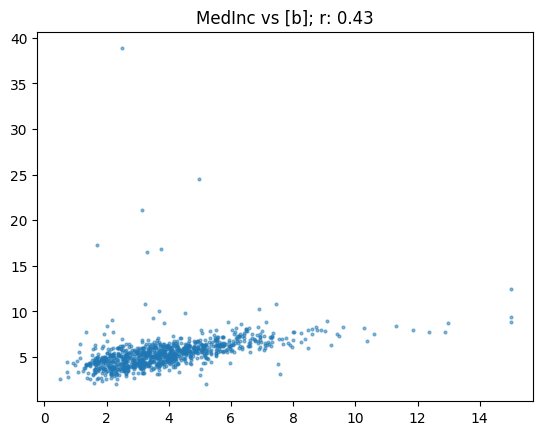

In [47]:
show_corr(housing, 'MedInc', 'AveRooms')

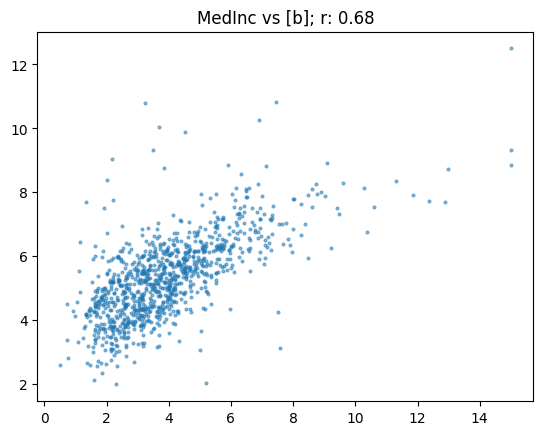

In [48]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

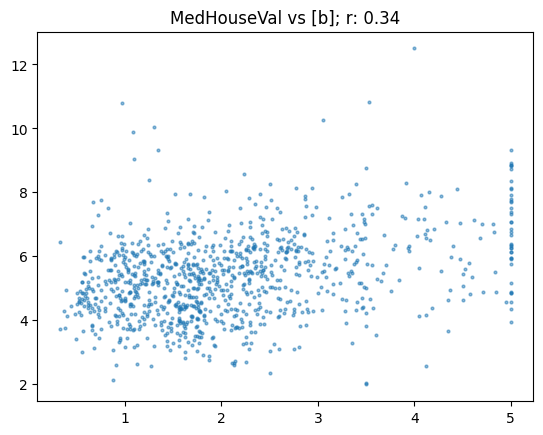

In [49]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

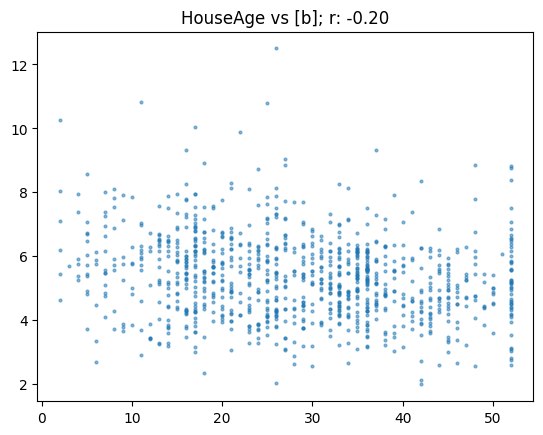

In [50]:
show_corr(subset, 'HouseAge', 'AveRooms')

## Training our model

In [51]:
from transformers import TrainingArguments, Trainer

In [52]:
bs = 128
epochs = 4


In [53]:
lr = 8e-5

In [55]:
args = TrainingArguments(
    'outputs', 
    learning_rate=lr, 
    warmup_ratio=0.1, 
    lr_scheduler_type='cosine', 
    fp16=True,
    evaluation_strategy="epoch", 
    per_device_train_batch_size=bs, 
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, 
    weight_decay=0.01, 
    report_to='none'
    )


ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA devices.

`args = TrainingArguments(`
`    'outputs', `
`    learning_rate=lr, `
`    warmup_ratio=0.1, `
`    lr_scheduler_type='cosine', `
`    fp16=True, ` for speed
`    evaluation_strategy='epoch', `
`    per_device_train_batch_size=bs, `
`    per_device_eval_batch_size=bs*2,`
`    num_train_epochs=epochs,`
`    weight_decay=0.01, `
`    report_to='none'`
`    )`